# Loading Libraries

In [23]:
import os
import shutil
import random
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PIL
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, fbeta_score

colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
device

'cuda'

# Functions

## Visualization

In [25]:
# Function to plot samples
def plot_samples(images, N=5):
    ps = random.sample(range(0, images.shape[0]), N**2)
    f, axarr = plt.subplots(N, N, figsize=(10, 10))
    p = 0
    for i in range(N):
        for j in range(N):
            im = images[ps[p]].transpose(1, 2, 0)
            im = im / 2 + 0.5  # Unnormalize the image
            axarr[i, j].imshow(im)
            axarr[i, j].axis('off')
            p += 1
    plt.show()

In [ ]:
def display_filters(weights, filename):
    N = int(np.ceil(np.sqrt(weights.shape[0])))
    f, axarr = plt.subplots(N, N, figsize=(12, 12))
    scaled = (weights - weights.min()) / (weights.max() - weights.min())  # Scale the weights for better plotting

    p = 0
    for i in range(N):
        for j in range(N):
            # Empty plot white when out of kernels to display
            if p >= scaled.shape[0]:
                krnl = torch.ones((scaled.shape[2], scaled.shape[3], 3))
            else:
                if scaled.shape[1] == 1:
                    krnl = scaled[p, :, :, :].permute(1, 2, 0)
                    axarr[i, j].imshow(krnl, cmap="gray")
                elif scaled.shape[1] == 3:
                    krnl = scaled[p, :, :, :].permute(1, 2, 0)
                    axarr[i, j].imshow(krnl)
                else:
                    krnl = scaled[p, 0, :, :]
                    axarr[i, j].imshow(krnl, cmap="gray")
            axarr[i, j].axis("off")
            p += 1

    # Save the figure
    plt.savefig(filename)

    # Show the plot
    plt.show()

In [ ]:
def get_conv_layers(network):
    conv_layers = []
    conv_layers_names = []
    for name, module in network.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append(module)
            conv_layers_names.append(name)
    return conv_layers, conv_layers_names

In [ ]:
def visualize_conv_filters(model, model_folder):
    conv_result_folder = os.path.join(model_folder, 'conv_layers')
    os.makedirs(conv_result_folder, exist_ok=True)
    conv_layers, _ = get_conv_layers(model)

    # Now you can proceed with your existing code
    for i, conv_layer in enumerate(conv_layers):
        print(f"Filters of Conv Layer {i+1}:")
        filters = conv_layer.weight.data.clone().cpu()
        filename = os.path.join(conv_result_folder, f"conv_layer_{i+1}_filters.png")  # Filename for saving the figure
        display_filters(filters, filename)

## Train and Test

In [26]:
def correct_predictions(predicted_batch, label_batch):
    pred = predicted_batch.argmax(dim=1, keepdim=True)
    return pred.eq(label_batch.view_as(pred)).sum().item()

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

def train_epoch(epoch, train_loader, network, optimizer, criterion, hparams, file_path):
    network.train()
    device = hparams['device']
    network.to(device)
    avg_loss = 0
    with open(file_path, 'a') as file:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = network(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if batch_idx % hparams['log_interval'] == 0:
                log_str = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                           f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\n')
                file.write(log_str)
                print(log_str, end='')  # print without adding an extra new line
    return avg_loss / len(train_loader)

def validation_epoch(validation_loader, network, hparams, file_path):
    network.eval()
    device = hparams['device']
    validation_loss = 0
    correct = 0
    with torch.no_grad(), open(file_path, 'a') as file:
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            validation_loss += F.cross_entropy(output, target, reduction='sum').item()
            correct += correct_predictions(output, target)
        validation_loss /= len(validation_loader.dataset)
        test_acc = 100. * correct / len(validation_loader.dataset)
        log_str = (f'\nValidation set: Average loss: {validation_loss:.4f}, Accuracy: {correct}/{len(validation_loader.dataset)} '
                   f'({test_acc:.0f}%)\n')
        file.write(log_str)
        print(log_str, end='')  # print without adding an extra new line
    return validation_loss, test_acc

## Plotting Results, Training and Testing Losses

In [27]:
def plot_and_save_results(tr_losses, val_losses, val_accs, filepath):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(14, 6))

    # Training and Testing Losses
    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Training Loss', color='#1f77b4', linewidth=2, marker='o')
    plt.plot(val_losses, label='Validation Loss', color='#ff7f0e', linewidth=2, marker='x')
    plt.title('Training and Validation Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Testing Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accs, label='Validation Accuracy', color='green', linewidth=2, marker='^')
    plt.title('Validation Accuracy Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig(filepath, dpi=300)
    plt.show()

In [28]:
def display_results(y_true, y_preds, class_labels):
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds)).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)

    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")
    return results, conf_mat

def plot_confusion_matrix(conf_mat, filepath):
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=sns.color_palette("icefire", as_cmap=True), xticklabels=conf_mat.columns, yticklabels=conf_mat.index)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(filepath, dpi=300)
    plt.show()

In [29]:
def plot_predictions(images, y_true, y_preds, class_indices, filepath, num_samples=20):
    
    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(len(images), size=num_samples, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        # Convert from PyTorch format (C, H, W) to image format (H, W, C)
        ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
        
        # Set title with predicted and true labels
        ax.set_title(f"{class_indices[pred_idx]}\n(True: {class_indices[true_idx]})", 
                     color=("green" if pred_idx == true_idx else "red"))
    
    plt.tight_layout()
    plt.savefig(filepath, dpi=300)
    plt.show()

## Setting-up Hyperparameters

In [30]:
hparams = {
    'batch_size': 512,
    'num_epochs': 15,
    'learning_rate': 0.001,
    'weight_decay': 0.001,
    'log_interval': 10,
    'device': device,
    'num_classes': 10
}

## Brief Overview of the Data

In [31]:
DATASET = "./data/EuroSAT_RGB"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


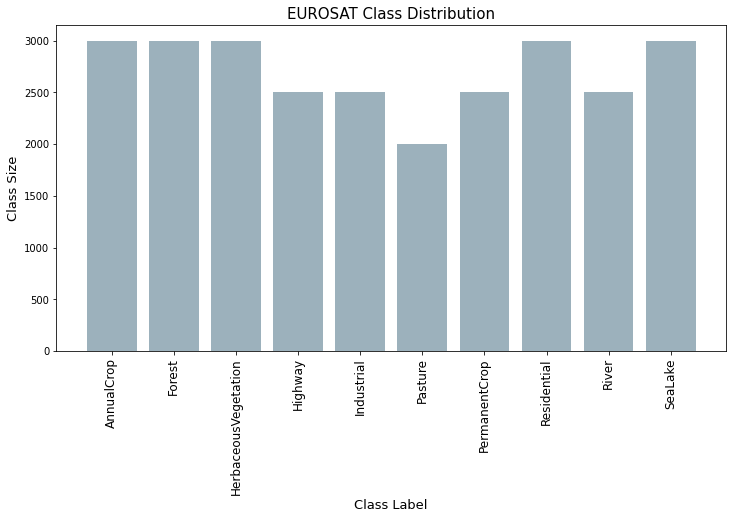

In [41]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center', color= colors[1])
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=90)
plt.xlabel('Class Label', fontsize=13)
plt.ylabel('Class Size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [42]:
print(f'Dataset Size: {sum(counts.values())}')

Dataset Size: 27000


The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets.

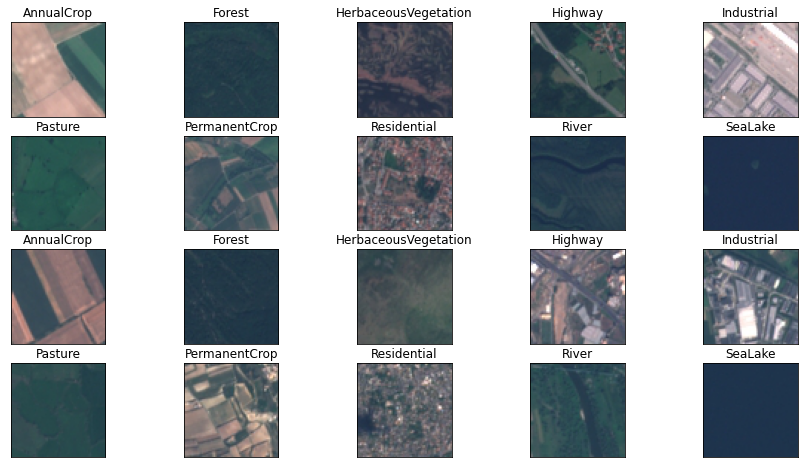

In [43]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)


Upon reviewing the various class previews, we observe certain commonalities and distinct contrasts among them.

Classes depicting urban settings like `Highways`, `Residential` areas, and `Industrial` sites predominantly feature man-made structures and roadways.

Both `AnnualCrops` and `PermanentCrops` classes display agricultural areas, characterized by straight lines marking different crop fields.

In contrast, classes such as `HerbaceousVegetation`, `Pasture`, and `Forests` represent natural landscapes. `Rivers`, also a part of the natural landscape category, are somewhat more distinguishable from these other natural classes.

Analyzing the imagery content might give insights into potential class confusions. For instance, a `River` image could be misidentified as a `Highway`. Similarly, an image showing a highway junction with nearby buildings might be confused for an `Industrial` area. To overcome these challenges, it's crucial to develop a classifier that can adeptly discern these subtle differences.

Regarding Sentinel-2 satellite imagery, it's possible to access over 10 additional spectral bands. For instance, the `Near-Infrared Radiation (NIR)` band is available in this dataset and can be utilized to create indices that visualize the presence or absence of radiation in an image. However, this dataset lacks NIR wavelength bands, rendering this approach infeasible for our current analysis. Nonetheless, it's important to note that NIR data could offer an alternative method for tackling this classification task.

# Dataset

## Creating Train, Validation and Test Directories

In [44]:
TRAIN_DIR = './data/train'
VALID_DIR = './data/valid'
TEST_DIR = './data/test'

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VALID_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# And open_project folder
os.makedirs(f'../open_project/', exist_ok=True)

# create class label subdirectories in train and test
for l in LABELS:
    os.makedirs(os.path.join(TRAIN_DIR, l), exist_ok=True)
    os.makedirs(os.path.join(VALID_DIR, l), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, l), exist_ok=True)

## Splitting Data to Train and Test

In [45]:
# Creating a dictionary with image paths and labels
data = {os.path.join(DATASET, l, img): l for l in LABELS for img in os.listdir(os.path.join(DATASET, l))}

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

# First split: Splitting into training and temporary set (combining test and validation)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=69)  # 30% for test + validation

for train_idx, temp_idx in split.split(X, y):
    train_paths = X[train_idx].tolist()
    temp_paths = X[temp_idx].tolist()

# Second split: Splitting the temporary set into test and validation
split_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=69)  # 50% of 30% -> 15% each for test and validation
y_temp = y.iloc[temp_idx]

for test_idx, val_idx in split_temp.split(pd.Series(temp_paths), y_temp):
    test_paths = pd.Series(temp_paths).iloc[test_idx].tolist()
    val_paths = pd.Series(temp_paths).iloc[val_idx].tolist()

# Define new paths without using regex
new_train_paths = [path.replace(DATASET, TRAIN_DIR) for path in train_paths]
new_test_paths = [path.replace(DATASET, TEST_DIR) for path in test_paths]
new_val_paths = [path.replace(DATASET, VALID_DIR) for path in val_paths]

train_path_map = zip(train_paths, new_train_paths)
test_path_map = zip(test_paths, new_test_paths)
val_path_map = zip(val_paths, new_val_paths)

## Uncomment Code Below when Run for First Time

In [ ]:
# Move the files
# print("Moving training files..")
# for old_path, new_path in tqdm(train_path_map):
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     shutil.copy(old_path, new_path)

# print("Moving testing files..")
# for old_path, new_path in tqdm(test_path_map):
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     shutil.copy(old_path, new_path)

# print("Moving validation files..")
# for old_path, new_path in tqdm(val_path_map):
#     os.makedirs(os.path.dirname(new_path), exist_ok=True)
#     shutil.copy(old_path, new_path)

## Loading and Preprocessing Train, Validation and Test Sets

In [46]:
# Define transformations for training
mean = [0.485, 0.456, 0.406] # Adjust as needed
std = [0.229, 0.224, 0.225] # Adjust as needed

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(60),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  
])

# Define transformations for testing (only normalization)
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  
])

# Create the dataset and dataloader for training
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)

# Optionally create the dataset and dataloader for validation
valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=test_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=hparams['batch_size'], shuffle=False)

# Create the dataset and dataloader for testing
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False)

In [47]:
print(f'Train Dataset Size: {len(train_dataset)}')
print(f'Validation Dataset Size: {len(valid_dataset)}')
print(f'Test Dataset Size: {len(test_dataset)}')

Train Dataset Size: 18900
Validation Dataset Size: 4050
Test Dataset Size: 4050


In [48]:
# Get Class indices dictionary
class_indices = train_dataset.class_to_idx
# Reverse the mapping to get indices to class names
idx_to_class = {v: k for k, v in class_indices.items()}
print(class_indices)
print(idx_to_class)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [49]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

## Visualize the Preprocessed Data

In [50]:
# Fetch the first batch of images from the trainloader
first_batch_images, _ = next(iter(train_loader))
first_image = first_batch_images[0].unsqueeze(0).to(hparams['device'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

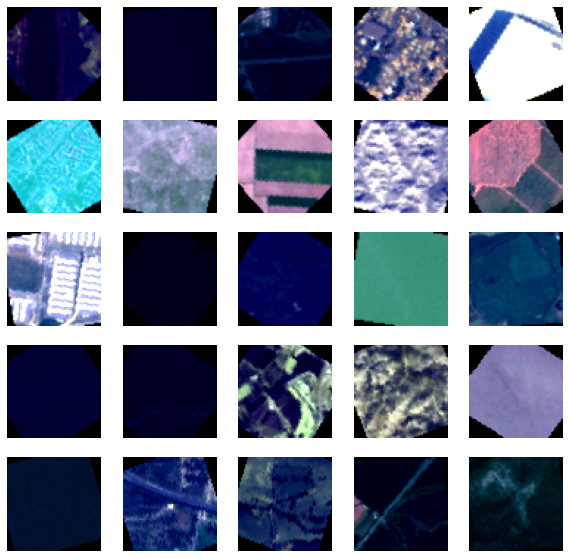

In [51]:
first_batch_images_np = first_batch_images.numpy()

# Plot samples from the first batch
plot_samples(first_batch_images_np)

# Model Instantiation

## EUROSatCNN

In [52]:
class EUROSatCNN(nn.Module):
    def __init__(self, num_classes):
        super(EUROSatCNN, self).__init__()
        self.num_classes = num_classes

        # First set of convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.dropout2 = nn.Dropout(0.25)

        # Third set of convolutional layers
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # output size: 8x8
        self.dropout3 = nn.Dropout(0.25)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 128)  # 8x8 is the size after pooling layers
        self.relu7 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, self.num_classes)  # Assuming 10 classes
    
    def forward(self, x):
        # First set of layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second set of layers
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third set of layers
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten the output
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

## Function Instatiating Specific Model

In [54]:
def compile_model(cnn_base, num_classes, file_path):
    # Choose the base model and modify the classifier
    if cnn_base in ['ResNet50', 'ResNet152']:
        if cnn_base == 'ResNet50':
            model = models.resnet50(pretrained=True)
            # Freeze the parameters
            for param in model.parameters():
                param.requires_grad = False
            # Replace the final fully connected layer
            # Extend the classifier
            num_ftrs = model.fc.in_features
        elif cnn_base == 'ResNet152':
            model = models.resnet152(pretrained=True)
            # Freeze the parameters
            for param in model.parameters():
                param.requires_grad = False
            # Replace the final fully connected layer
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
        else:
            raise ValueError("Unsupported ResNet model base")
    
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )
    
    elif cnn_base in ['VGG16', 'VGG19']:
        if cnn_base == 'VGG16':
            model = models.vgg16(pretrained=True)
            # Freeze the parameters
            for param in model.parameters():
                param.requires_grad = False
        
        elif cnn_base == 'VGG19':
            model = models.vgg19(pretrained=True)
            # Freeze the parameters
            for param in model.parameters():
                param.requires_grad = False
        else:
            raise ValueError("Unsupported VGG model base")
        
        # Modify and extend the classifier
        model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    elif cnn_base == "EUROSatCNN":
        model = EUROSatCNN(num_classes)
    
    # Get the current datetime
    dt = datetime.now()

    # Format the datetime as a string in the specified format: year_month_day_hour_minute
    str_dt = dt.strftime("%Y_%m_%d_%H_%M")
    
    file_path = os.path.join(file_path, f'architecture_{str_dt}.txt')
    
    total_params, trainable_params, non_trainable_params = count_parameters(model)
    
    with open(file_path, 'a') as file:
        file.write('-------------------------------------------------------------------\n')
        file.write(f'{(model)}\n')
        file.write('-------------------------------------------------------------------\n')
        file.write(f'Total parameters in the model: {total_params}\n')
        file.write(f'Trainable parameters in the model: {trainable_params}\n')
        file.write(f'NON-Trainable parameters in the model: {non_trainable_params}\n')
        file.write('-------------------------------------------------------------------\n')
    
    print('-------------------------------------------------------------------\n')
    print(f'{(model)}\n')
    print('-------------------------------------------------------------------\n')
    print(f'Total parameters in the model: {total_params}\n')
    print(f'Trainable parameters in the model: {trainable_params}\n')
    print(f'NON-Trainable parameters in the model: {non_trainable_params}\n')
    print('-------------------------------------------------------------------\n')

    return model, str_dt

# Training Process

In [57]:
def training_process(network, nework_name, model_folder, str_dt):
    
    train_log_path = os.path.join(model_folder, f'training_log_{str_dt}.txt')
    # valid_log_path = os.path.join(model_folder, f'validation_log_{str_dt}_.txt')
    losses_figure_path = os.path.join(model_folder, f'losses_{str_dt}_.png')
    
    # Initialize variables for Early Stopping and Model Checkpoint
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    patience = 10  # For early stopping
    

    # Define the optimizer with or without L2 regularization
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'])

    # Define the criterion
    criterion = nn.CrossEntropyLoss()

    # Initialize ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=0.001)

    early_stopping_triggered = False


    # Training and validation loop
    tr_losses, val_losses, val_accs = [], [], []

    # Start the timer
    start_time = time.time()

    for epoch in range(1, hparams['num_epochs'] + 1):
        train_loss = train_epoch(epoch, train_loader, network, optimizer, criterion, hparams, train_log_path)
        tr_losses.append(train_loss)
        val_loss, val_acc = validation_epoch(valid_loader, network, hparams, train_log_path)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    

        # Model Checkpoint
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            model_path = os.path.join(model_folder, f'best_model_epoch_{epoch}_dt_{str_dt}.pth')
            torch.save(network.state_dict(), model_path)
            print(f"Checkpoint saved at {model_path} \n")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early Stopping
        if epochs_no_improve == patience:
            print("Early stopping triggered. Exiting training loop. \n")
            early_stopping_triggered = True
            break

        # Learning Rate Scheduler Step
        scheduler.step(val_acc)

    if not early_stopping_triggered:
        print("Completed training for {} epochs \n".format(hparams['num_epochs']))
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Convert elapsed time to minutes and seconds
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)

    print(f'Total Training Time: {elapsed_mins}m {elapsed_secs}s \n')
    
    plot_and_save_results(tr_losses, val_losses, val_accs, losses_figure_path)
    
    return tr_losses, val_losses, val_accs, nework_name

# Models

Uncomment the respective `Model` which you want to train and test!

## ResNet50

In [56]:
model_folder = '../open_project/ResNet50'
os.makedirs(model_folder, exist_ok=True)
ResNet50_model, str_dt = compile_model('ResNet50', hparams['num_classes'], model_folder)

-------------------------------------------------------------------

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Seq

In [ ]:
tr_losses, val_losses, val_accs, network_name = training_process(ResNet50_model, "ResNet50", model_folder, str_dt)

In [ ]:
model = ResNet50_model

## ResNet152

In [ ]:
# model_folder = '../open_project/ResNet152'
# os.makedirs(model_folder, exist_ok=True)
# ResNet152_model, str_dt = compile_model('ResNet152', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, network_name = training_process(ResNet152_model, "ResNet152", model_folder, str_dt)

## VGG16

In [ ]:
# model_folder = '../open_project/VGG16'
# os.makedirs(model_folder, exist_ok=True)
# VGG16_model, str_dt = compile_model('VGG16', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, network_name = training_process(VGG16_model, "VGG16", model_folder, str_dt)


In [ ]:
# model = VGG16_model

## VGG19

In [ ]:
# model_folder = '../open_project/VGG19'
# os.makedirs(model_folder, exist_ok=True)
# VGG19_model, str_dt = compile_model('VGG19', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, network_name = training_process(VGG19_model, "VGG19", model_folder, str_dt)


In [ ]:
# model = VGG19_model

## EUROSatCNN No Fine Tuning

In [ ]:
# model_folder = '../open_project/EUROSatCNN_no_fine_tune'
# os.makedirs(model_folder, exist_ok=True)
# EUROSatCNN_no_fine_tune, str_dt = compile_model('EUROSatCNN', hparams['num_classes'], model_folder)

In [ ]:
# tr_losses, val_losses, val_accs, nework_name = training_process(EUROSatCNN_no_fine_tune, "EUROSatCNN_no_fine_tune", model_folder, str_dt)

In [ ]:
# model = EUROSatCNN_no_fine_tune

# Loading Model for Testing

The following chunk can be used in case you want to load a specific model and check its `predictability power`!

In [63]:
model = EUROSatCNN(hparams['num_classes'])
model_folder = '../open_project/EUROSatCNN_no_fine_tune'
model_version = "best_model_2024_01_09_00_49.pth"
# Extracting the date and time part using string slicing
str_dt = model_version[len("best_model_"):-len(".pth")]
model_path = os.path.join(model_folder, model_version)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

EUROSatCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kerne

# Model Evaluation

## Train Predictions

In [77]:
# Load a batch of images and their labels from the test_loader
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

# Predict labels
model.eval()
model.to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

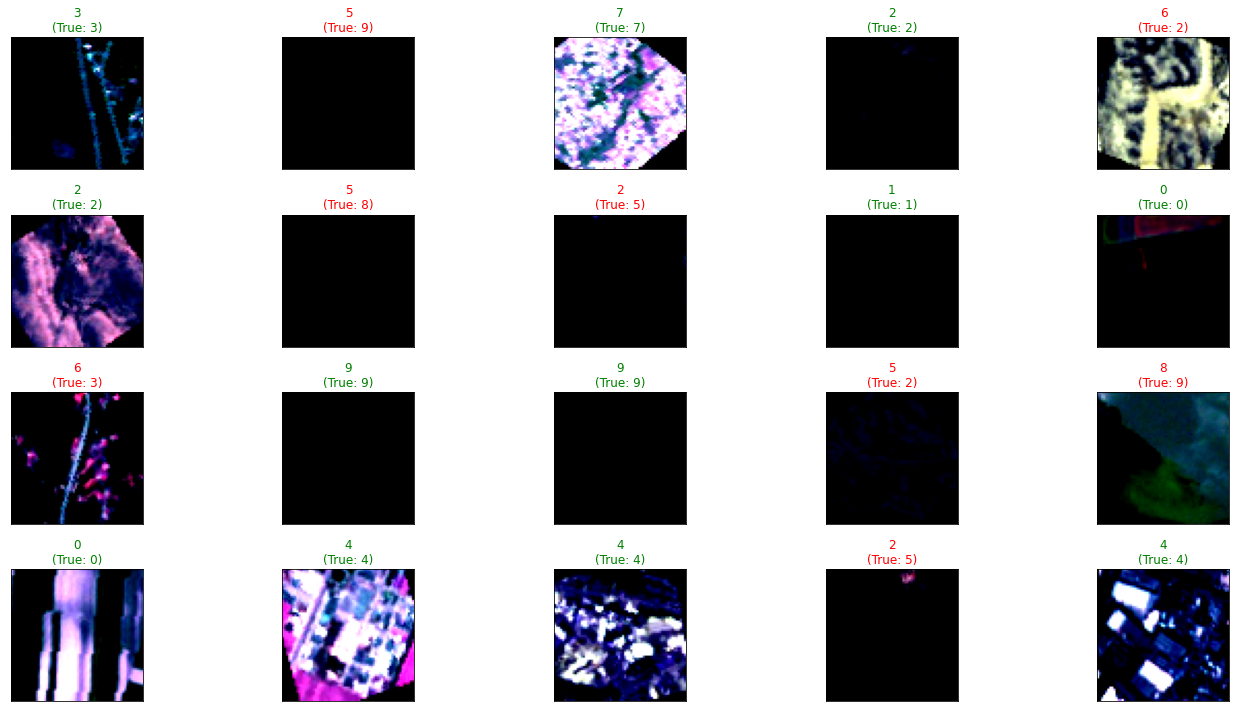

In [78]:
# Map predicted and true labels back to class names
predicted_labels = [idx_to_class[idx] for idx in predicted.cpu().numpy()]
true_labels = [idx_to_class[idx] for idx in labels.cpu().numpy()]

filename = os.path.join(model_folder, f'plot_train_predictions_{str_dt}.png')

# Visualize predictions
plot_predictions(images, true_labels, predicted_labels, class_indices, filename)

In [79]:
# Initialize lists to store true and predicted labels
all_labels = []
all_predictions = []

# Predict labels for the entire test dataset
model.eval()
model.to(device)
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to the lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

In [80]:
# Now you can pass all_labels and all_predictions to the display_results function
prf, conf_mat = display_results(all_labels, all_predictions, class_indices)


filename = os.path.join(model_folder, f'prf_train_{str_dt}.csv')

# Save the DataFrame to a CSV file
prf.to_csv(filename, index=False)

Accuracy: 0.7321164021164022
Global F2 Score: 0.7321164021164022


In [81]:
prf

,Precision,Recall,F-Score,Support
0,0.744559,0.863333,0.799559,2100.0
1,0.749719,0.951429,0.838615,2100.0
2,0.602558,0.628095,0.615062,2100.0
3,0.676471,0.446857,0.538197,1750.0
4,0.866235,0.840000,0.852916,1750.0
5,0.632464,0.779286,0.698240,1400.0
6,0.512673,0.762857,0.613229,1750.0
7,0.980366,0.713333,0.825799,2100.0
8,0.744461,0.576000,0.649485,1750.0
9,0.984486,0.725238,0.835207,2100.0


In [82]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,1813,16,23,20,0,82,86,0,46,14
Forest,1,1998,29,6,0,55,0,1,5,5
HerbaceousVegetation,54,40,1319,39,17,81,505,16,25,4
Highway,199,9,89,782,55,81,395,6,134,0
Industrial,11,0,74,43,1470,0,131,7,14,0
Pasture,16,89,94,15,0,1091,22,0,73,0
PermanentCrop,153,1,217,25,6,5,1335,0,8,0
Residential,0,9,329,57,147,0,59,1498,1,0
River,162,29,14,169,2,294,71,0,1008,1
SeaLake,26,474,1,0,0,36,0,0,40,1523


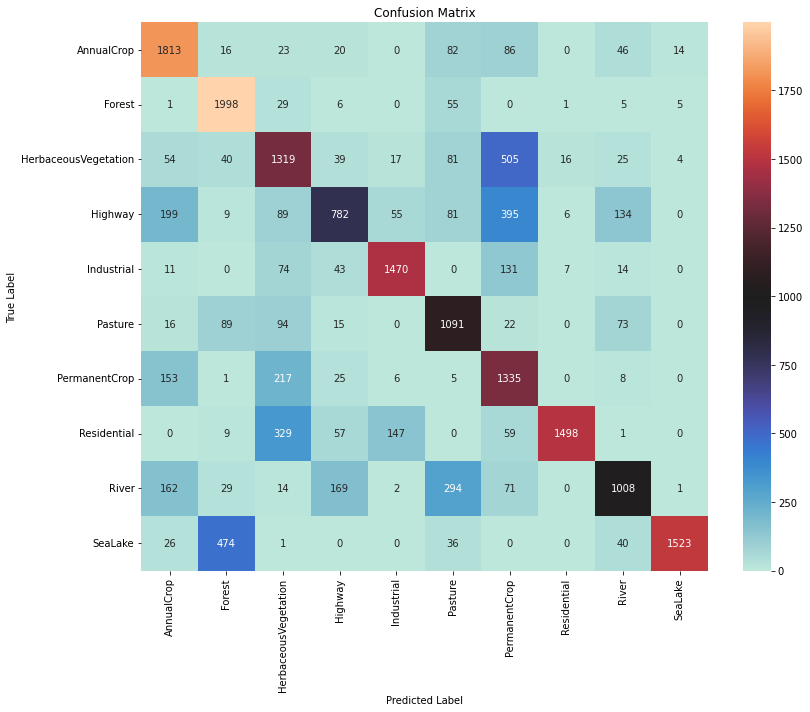

In [83]:
# Use the function to plot the confusion matrix
filename = os.path.join(model_folder, f'train_cm_{str_dt}.png')
plot_confusion_matrix(conf_mat, filename)

## Test Predictions

In [68]:
# Load a batch of images and their labels from the test_loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Predict labels
model.eval()
model.to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

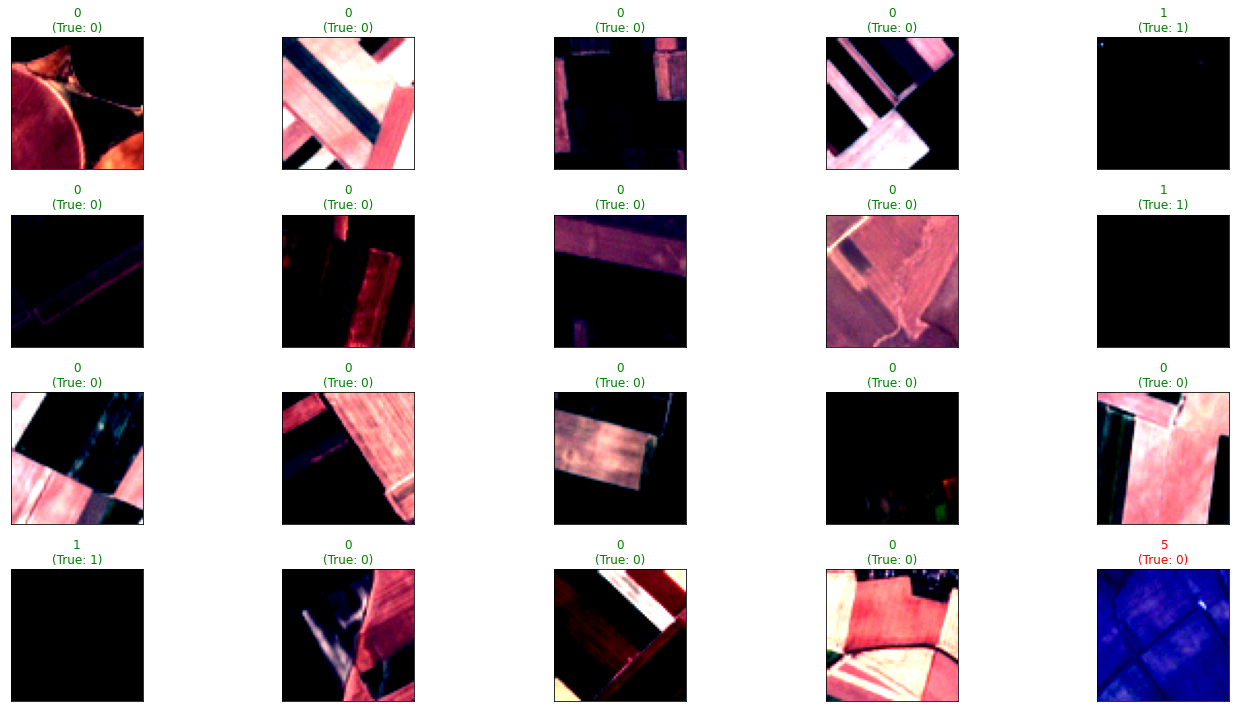

In [71]:
# Map predicted and true labels back to class names
predicted_labels = [idx_to_class[idx] for idx in predicted.cpu().numpy()]
true_labels = [idx_to_class[idx] for idx in labels.cpu().numpy()]

filename = os.path.join(model_folder, f'plot_test_predictions_{str_dt}.png')

# Visualize predictions
plot_predictions(images, true_labels, predicted_labels, class_indices, filename)

In [72]:
# Initialize lists to store true and predicted labels
all_labels = []
all_predictions = []

# Predict labels for the entire test dataset
model.eval()
model.to(device)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels to the lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

In [73]:
# Now you can pass all_labels and all_predictions to the display_results function
prf, conf_mat = display_results(all_labels, all_predictions, class_indices)


filename = os.path.join(model_folder, f'prf_test_{str_dt}.csv')

# Save the DataFrame to a CSV file
prf.to_csv(filename, index=False)

Accuracy: 0.8123456790123457
Global F2 Score: 0.8123456790123457


In [74]:
prf

,Precision,Recall,F-Score,Support
0,0.871734,0.815556,0.842710,450.0
1,0.856311,0.980000,0.913990,450.0
2,0.807910,0.635556,0.711443,450.0
3,0.754325,0.581333,0.656627,375.0
4,0.957983,0.912000,0.934426,375.0
5,0.693215,0.783333,0.735524,300.0
6,0.569728,0.893333,0.695742,375.0
7,0.932203,0.977778,0.954447,450.0
8,0.741071,0.664000,0.700422,375.0
9,0.994723,0.837778,0.909530,450.0


In [75]:
conf_mat

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,367,2,4,4,0,21,39,0,13,0
Forest,0,441,2,1,0,6,0,0,0,0
HerbaceousVegetation,2,7,286,8,1,18,108,15,5,0
Highway,19,1,14,218,9,9,71,5,29,0
Industrial,0,0,3,11,342,0,6,7,6,0
Pasture,2,15,19,4,0,235,8,0,16,1
PermanentCrop,6,0,22,8,0,0,335,4,0,0
Residential,0,1,1,2,5,0,1,440,0,0
River,21,2,3,33,0,45,20,1,249,1
SeaLake,4,46,0,0,0,5,0,0,18,377


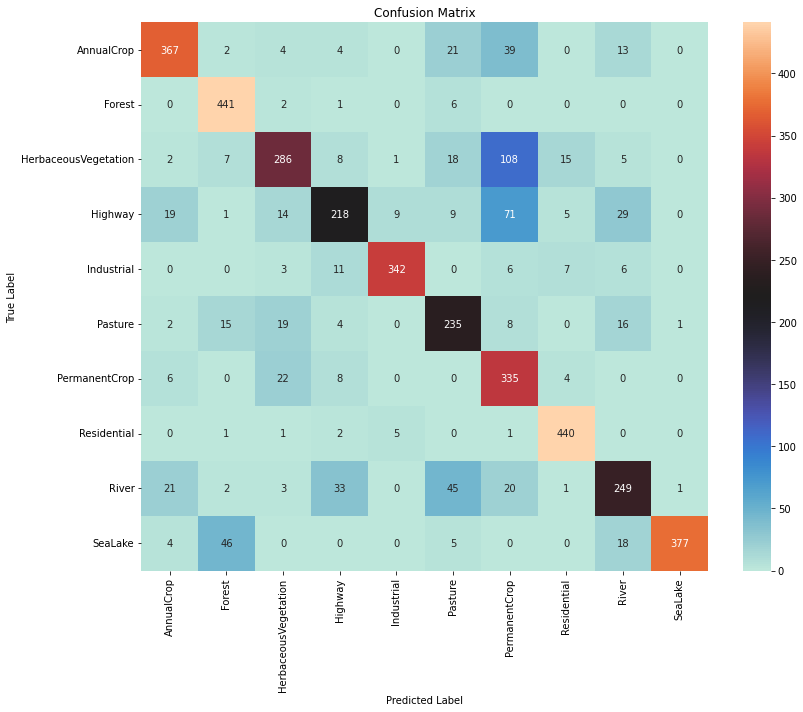

In [76]:
# Use the function to plot the confusion matrix
filename = os.path.join(model_folder, f'test_cm_{str_dt}.png')
plot_confusion_matrix(conf_mat, filename)

# Model Interpretability

Filters of Conv Layer 1:


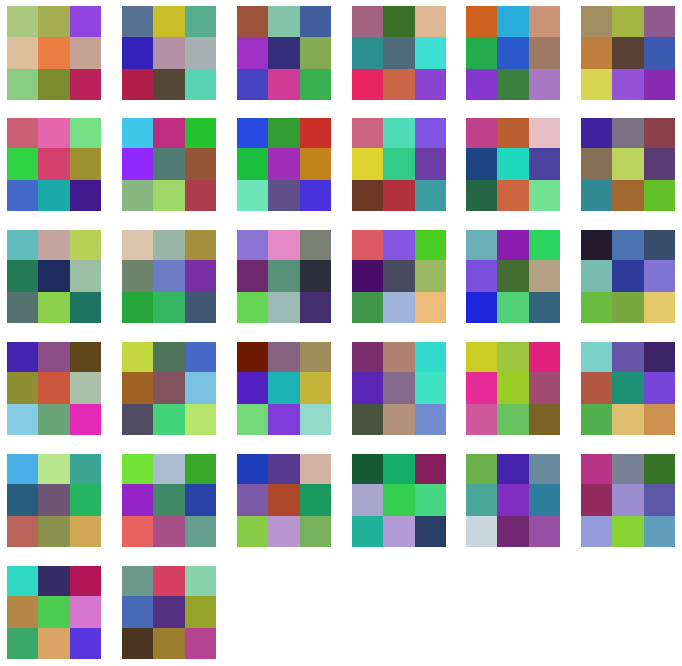

Filters of Conv Layer 2:


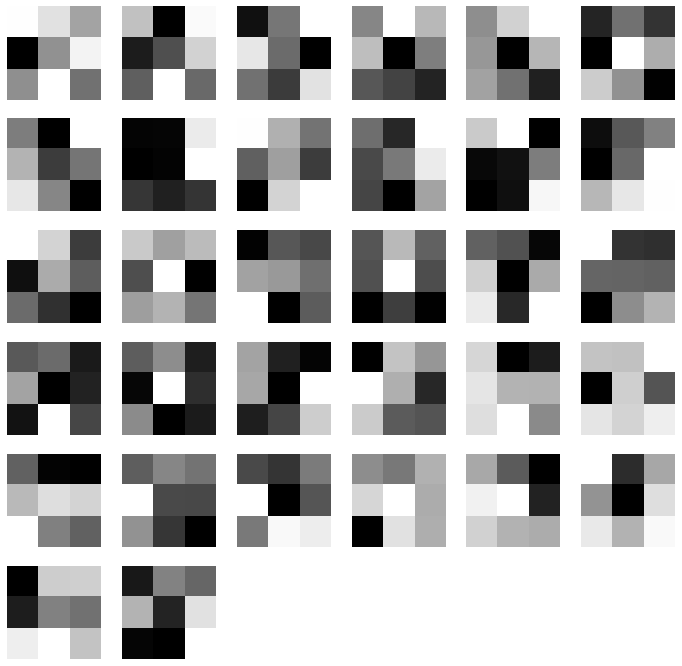

Filters of Conv Layer 3:


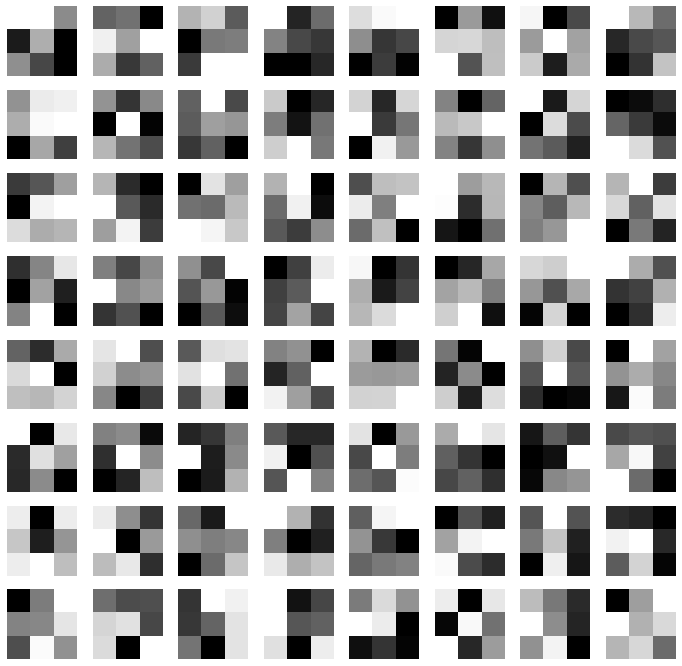

Filters of Conv Layer 4:


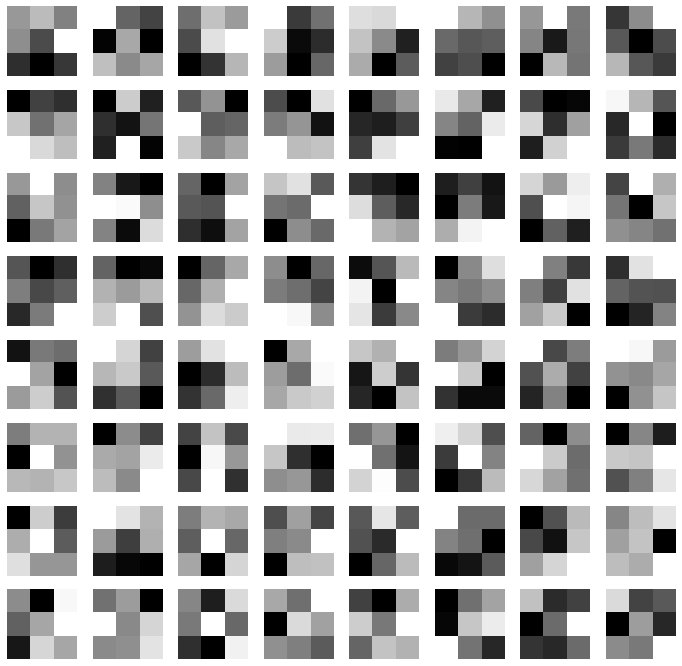

Filters of Conv Layer 5:


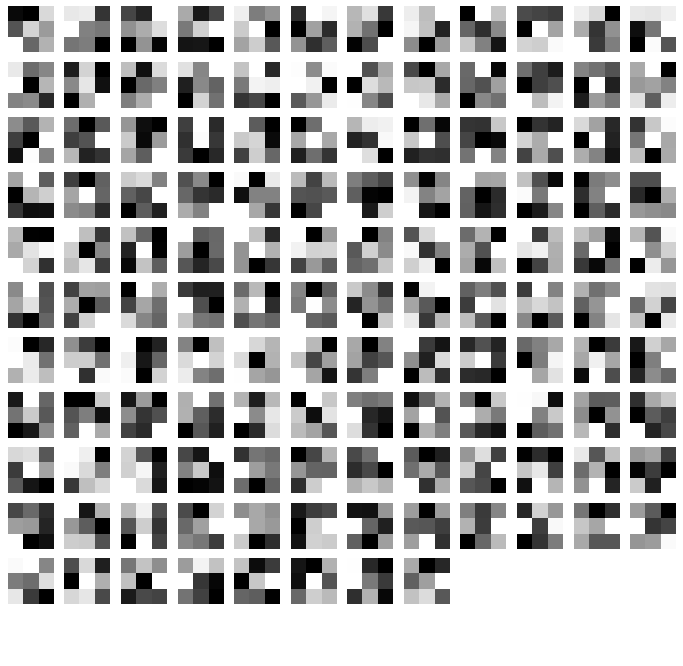

Filters of Conv Layer 6:


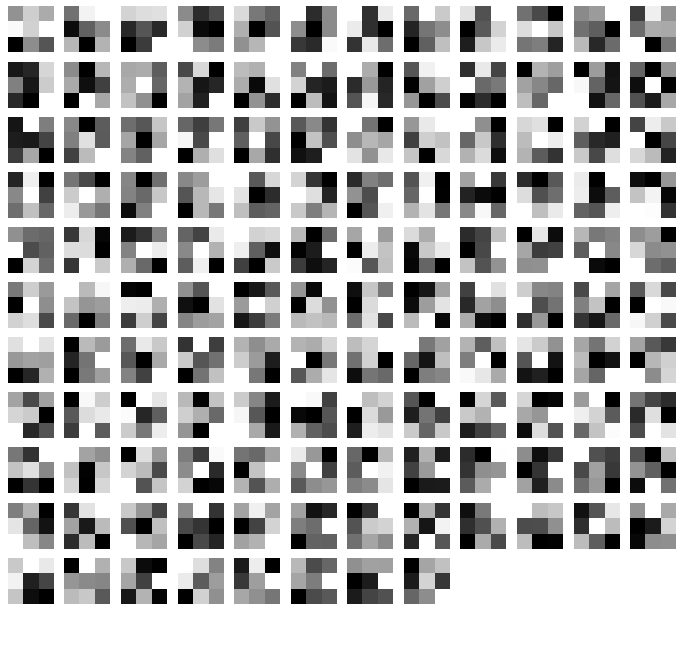

In [105]:
visualize_conv_filters(model, model_folder)

In [ ]:
class ActivationExtractor(nn.Module):
    def __init__(self, original_model, stop_layer):
        super(ActivationExtractor, self).__init__()
        self.stop_layer = stop_layer

        # Identify the last convolutional layer (or equivalent) for different architectures
        if isinstance(original_model, models.ResNet):
            # For ResNet models, everything before the fully connected layer is considered as features
            self.features = nn.Sequential(*list(original_model.children())[:-2])
            self.fc = list(original_model.children())[-1]
        
        elif isinstance(original_model, models.VGG):
            # For VGG models, we consider the classifier part as the fully connected layers
            self.features = original_model.features
            self.classifier = original_model.classifier

        elif isinstance(original_model, EUROSatCNN):
            # For the EUROSatCNN model, follow the structure defined in your class
            # Assuming the structure remains as you described
            self.features = nn.Sequential(
                original_model.conv1,
                original_model.bn1,
                original_model.relu1,
                original_model.conv2,
                original_model.bn2,
                original_model.relu2,
                original_model.pool1,
                original_model.dropout1,
                original_model.conv3,
                original_model.bn3,
                original_model.relu3,
                original_model.conv4,
                original_model.bn4,
                original_model.relu4,
                original_model.pool2,
                original_model.dropout2,
                original_model.conv5,
                original_model.bn5,
                original_model.relu5,
                original_model.conv6,
                original_model.bn6,
                original_model.relu6,
                original_model.pool3,
                original_model.dropout3,
                original_model.flatten
            )
            self.fc1 = original_model.fc1
            self.fc2 = original_model.fc2

        # Define the classifier part dynamically based on the stopping layer
        if self.stop_layer == 'fc1':
            if isinstance(original_model, models.ResNet) or isinstance(original_model, models.VGG):
                self.classifier = nn.Identity()
            else:  # For EUROSatCNN
                self.classifier = self.fc1
        elif self.stop_layer == 'fc2':
            if isinstance(original_model, models.ResNet) or isinstance(original_model, models.VGG):
                self.classifier = nn.Sequential(
                    self.fc,
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(self.fc.in_features, stop_layer)  # Adjust the output features
                )
            else:  # For EUROSatCNN
                self.classifier = nn.Sequential(
                    self.fc1,
                    original_model.relu7,
                    original_model.dropout4,
                    self.fc2
                )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = self.classifier(x)
        return x

## ResNet50

In [ ]:
# Initialize the extractor model
# Create extractors for each fully connected layer
extractor_fc1 = ActivationExtractor(model, stop_layer='fc1')
extractor_fc2 = ActivationExtractor(model, stop_layer='fc2')
# Ensure the extractor model is on the same device as the inputs
extractor_fc1.to(device)
extractor_fc2.to(device)

extractor_fc1

## ResNet152

## VGG16

## VGG19